# Radial Fourier Analysis scripting example
Sample data: Metallic glass

* Shuai Wei <shuai.wei@physik.rwth-aachen.de>, RWTH Aachen

* Alexander Kuball, Universität des Saarlandes

* Hongchu Du <h.du@fz-juelich.de>, ER-C, Forschungszentrum Jülich

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import numpy as np

import libertem.api as lt

In [4]:
ctx = lt.Context()

In [5]:
ds = ctx.load(
    'MIB',
    path='/cachedata/users/du/200_20190328_185735/default.hdr'
)
# ds.shape is (256, 256, 256, 256)
# Size: 8 GB

In [6]:
cx, cy = 134, 129

These parameters allow running the analysis on a consumer-grade computer
within a few minutes:

In [7]:
# rfa = ctx.create_radial_fourier_analysis(
#     dataset=ds,
#     cx=cx,
#     cy=cy,
#     ri=0,
#     ro=45,
#     n_bins=45,
#     max_order=12
# )

A workstation with a powerful multicore CPU is more suitable
for these parameters

In [8]:
rfa = ctx.create_radial_fourier_analysis(
    dataset=ds,
    cx=cx,
    cy=cy,
    ri=0,
    ro=120,
    n_bins=120,
    max_order=36
)

In [9]:
res = ctx.run(rfa)

## Calculate a spectrum for the entire scan as a function of radius

Note the "abs": The coefficients are complex numbers
with arbitrary phase angles.
We sum up the absolute values to ignore orientations,
otherwise they would cancel each other out.
Summing the actual values could yield texture information.

<IPython.core.display.Javascript object>


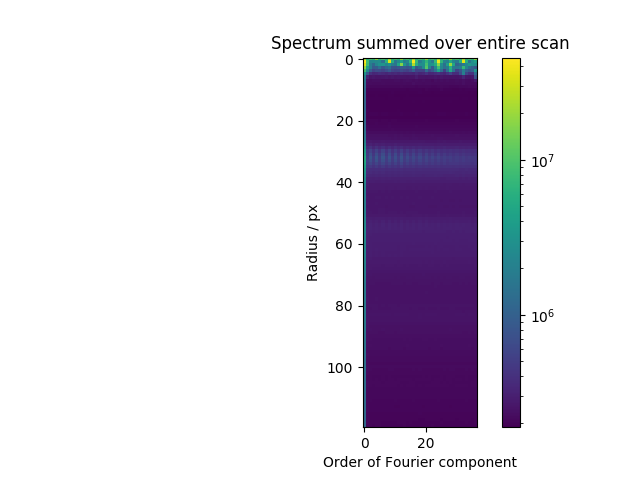

Text(0.5, 1.0, 'Spectrum summed over entire scan')

In [10]:
spectrum = np.abs(res.raw_results).sum(axis=(2, 3))
fig, axes = plt.subplots()
plt.imshow(spectrum, norm=colors.LogNorm())
plt.colorbar()
plt.xlabel("Order of Fourier component")
plt.ylabel("Radius / px")
plt.title("Spectrum summed over entire scan")

## Summing the absolutes of all non-zero components

This is qualitatively equivalent to the variance after filtering the dataset radially with a low-pass filter.
High orders would have to be included and bins and Fourier transform would have to be normalized correctly
for this to be quantitatively equivalent to the variance, i.e. Fluctuation EM.

<IPython.core.display.Javascript object>


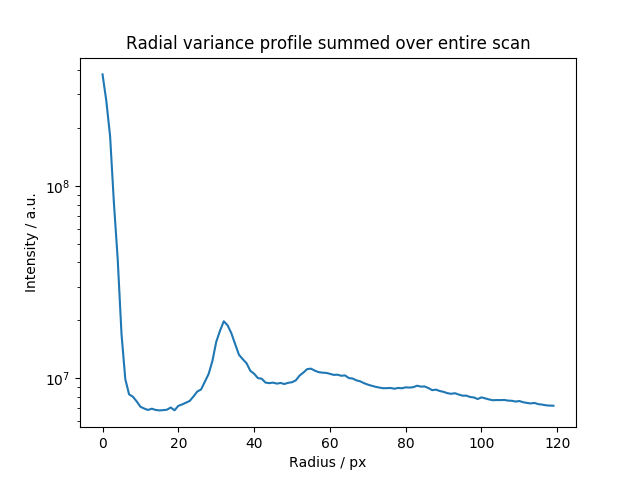

Text(0.5, 1.0, 'Radial variance profile summed over entire scan')

In [11]:
radial_variance = spectrum[:, 1:].sum(axis=1)
fig, axes = plt.subplots()
plt.plot(radial_variance)
plt.yscale('log')
plt.ylabel("Intensity / a.u.")
plt.xlabel("Radius / px")
plt.title("Radial variance profile summed over entire scan")

## We can do a radial profile of any order.

<IPython.core.display.Javascript object>


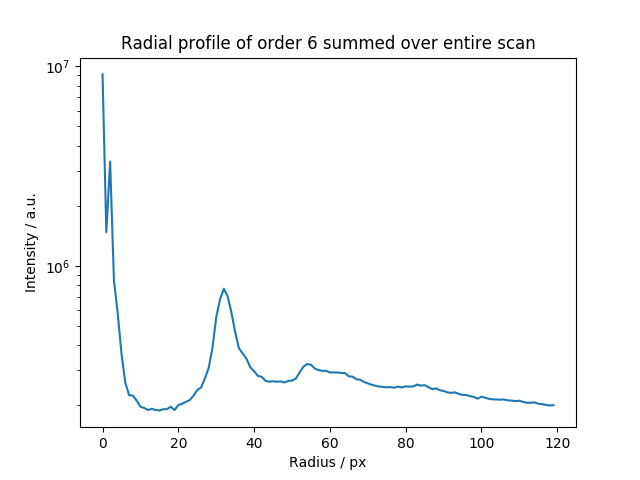

In [12]:
radial_six = spectrum[:, 6]
fig, axes = plt.subplots()
plt.title("Radial profile of order 6 summed over entire scan")
plt.plot(radial_six)
plt.ylabel("Intensity / a.u.")
plt.xlabel("Radius / px")
plt.yscale('log')

## The zero order component is just the radial sum.

<IPython.core.display.Javascript object>


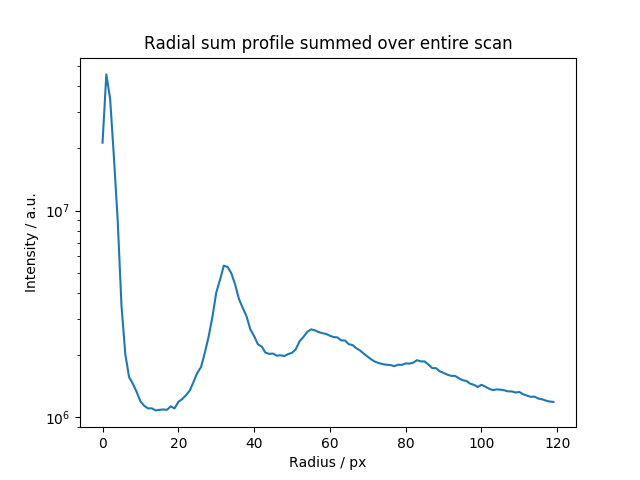

Text(0.5, 1.0, 'Radial sum profile summed over entire scan')

In [13]:
radial_sum = spectrum[:, 0]
fig, axes = plt.subplots()
plt.plot(radial_sum)
plt.yscale('log')
plt.ylabel("Intensity / a.u.")
plt.xlabel("Radius / px")
plt.title("Radial sum profile summed over entire scan")

We determined a "ring of interest" from the radial plots or spectrum and put it in these variables for subsequent use.

In [14]:
ri, ro = 30, 35

## We analyze which coefficients are present in that ring

Note that the coefficients contain higher harmonics! The one with the highest value is of interest.

<IPython.core.display.Javascript object>


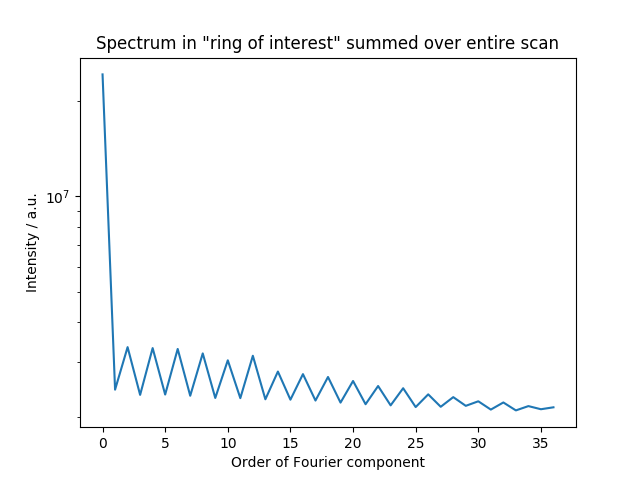

In [15]:
psd = spectrum[ri:ro].sum(axis=0)
fig, axes = plt.subplots()
plt.plot(psd)
plt.title("Spectrum in \"ring of interest\" summed over entire scan")
plt.ylabel("Intensity / a.u.")
plt.xlabel("Order of Fourier component")
plt.yscale('log')

## We calculate maps for selected orders across the scan

<IPython.core.display.Javascript object>


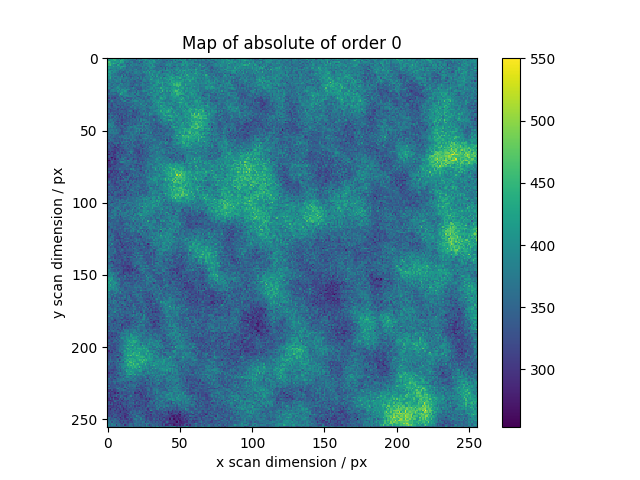

<IPython.core.display.Javascript object>


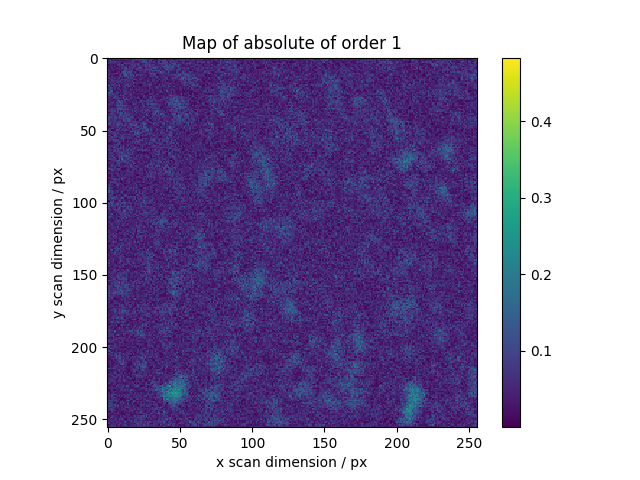

<IPython.core.display.Javascript object>


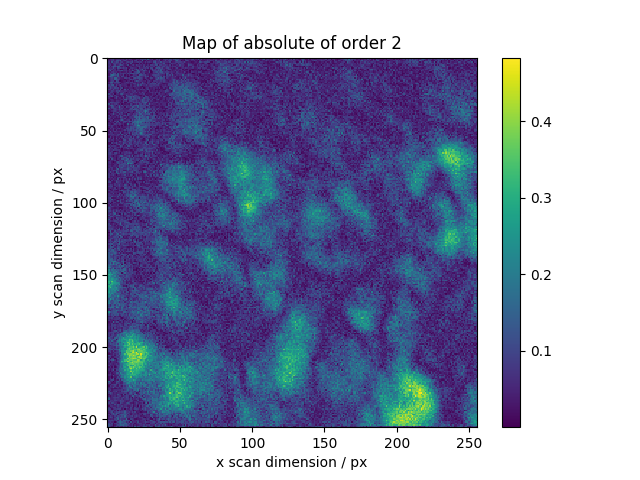

<IPython.core.display.Javascript object>


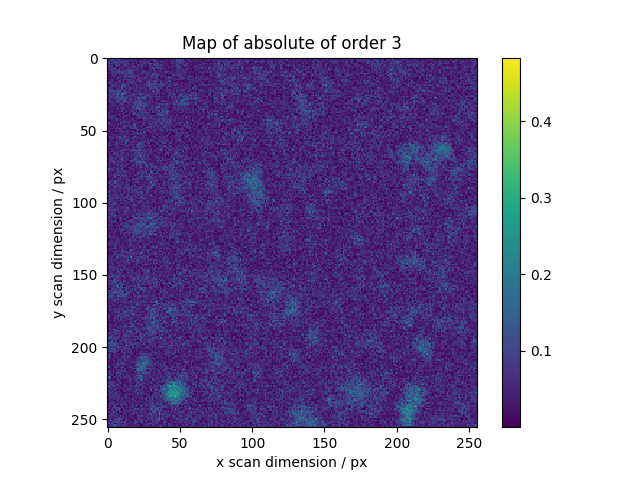

<IPython.core.display.Javascript object>


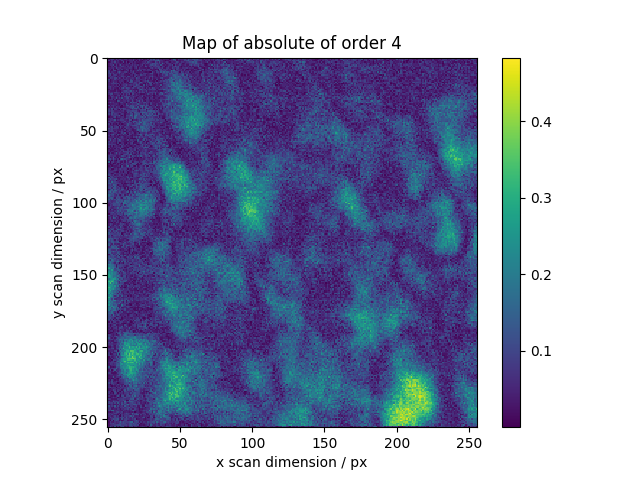

<IPython.core.display.Javascript object>


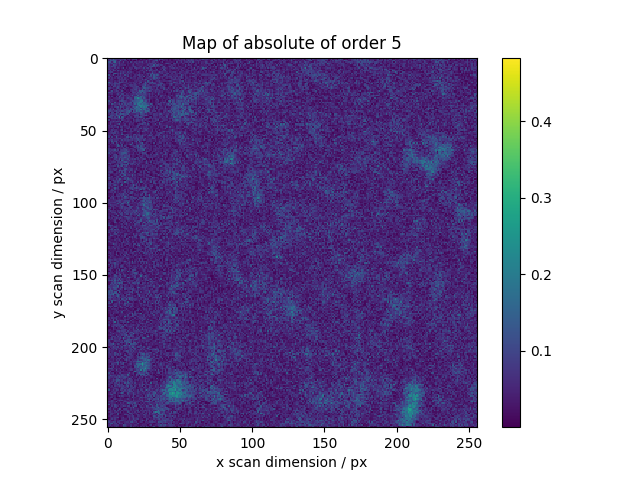

<IPython.core.display.Javascript object>


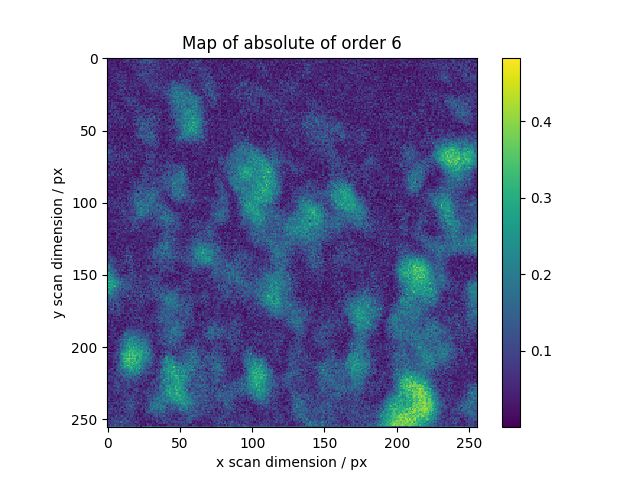

In [16]:
maps = res.raw_results[ri:ro].sum(axis=0)
# We normalize higher orders with the total integrated intensity
maps[1:] /= np.abs(maps[0])
absmaps = np.abs(maps)

vmin = absmaps[1:].min()
vmax = absmaps[1:].max()

# Plotting the absolute values gives the best overview.
fig, axes = plt.subplots()
plt.imshow(absmaps[0])
plt.colorbar()
plt.ylabel("y scan dimension / px")
plt.xlabel("x scan dimension / px")
plt.title("Map of absolute of order 0")

for o in range(1, 7):
    fig, axes = plt.subplots()
    plt.imshow(absmaps[o], vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.ylabel("y scan dimension / px")
    plt.xlabel("x scan dimension / px")
    plt.title("Map of absolute of order %s" % o)

## The phase gives information about orientation

<IPython.core.display.Javascript object>


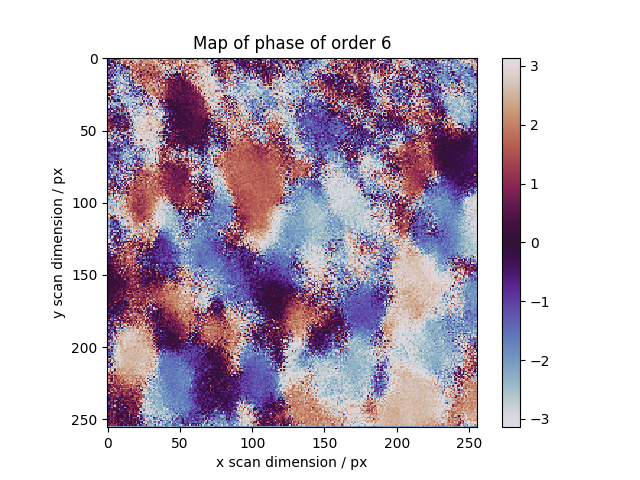

Text(0.5, 1.0, 'Map of phase of order 6')

In [19]:
fig, axes = plt.subplots()
plt.imshow(np.angle(maps[o]), cmap=cm.twilight)
plt.colorbar()
plt.ylabel("y scan dimension / px")
plt.xlabel("x scan dimension / px")
plt.title("Map of phase of order %s" % o)

## We determine which order is predominant

We reject values below a threshold to eliminate noise
Limit to 20 orders for colormap and only use "typical crystalline" orders
2, 4, 6 to determine the threshold.

<IPython.core.display.Javascript object>


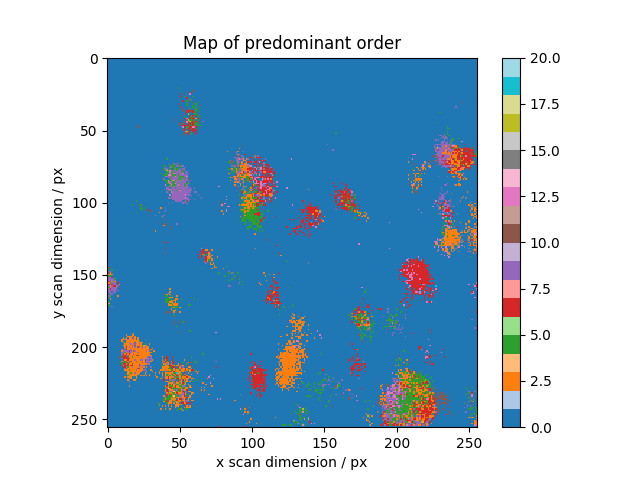

Text(0.5, 1.0, 'Map of predominant order')

In [18]:
below_threshold = absmaps[1:20] < absmaps[(2, 4, 6), ...].max() * 0.5
below_threshold = np.all(below_threshold, axis=0)
dominant = np.argmax(absmaps[1:20], axis=0) + 1
dominant[below_threshold] = 0

fig, axes = plt.subplots()
plt.imshow(dominant, cmap=cm.tab20, vmin=0, vmax=20)
plt.colorbar()
plt.ylabel("y scan dimension / px")
plt.xlabel("x scan dimension / px")
plt.title("Map of predominant order")